【项目08】  电商打折套路解析

作业要求
1、	从现有数据中，分析出“各个品牌都有多少商品参加了双十一活动？”
要求：
① 计算得到：商品总数、品牌总数
② 双十一当天在售的商品占比情况
（思考：是不是只有双十一当天在售的商品是“参与双十一活动的商品？”）
②	未参与双十一当天活动的商品，在双十一之后的去向如何？
③	真正参与双十一活动的品牌有哪些？
其各个品牌参与双十一活动的商品数量分布是怎样的？
   * 用bokeh绘制柱状图表示
提示：
① 数据的“id”字段为商品的实际唯一标识，“title”字段则为商品在网页上显示的名称
   * 仔细看数据可以发现，同一个id的title不一定一样（双十一前后）
② 数据的“店名”字段为品牌的唯一标识
③ 按照商品销售节奏分类，我们可以将商品分为7类
   A. 11.11前后及当天都在售 → 一直在售
   B. 11.11之后停止销售 → 双十一后停止销售
   C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售
   D. 11.11开始销售且当天停止 → 仅双十一当天有售
   E. 11.5 - 11.10 → 双十一前停止销售
   F. 仅11.11当天停止销售 → 仅双十一当天停止销售
   G. 11.12开始销售 → 双十一后上架
④ 未参与双十一当天活动的商品，可能有四种情况：
   con1 → 暂时下架（F）
   con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”），字符串查找特定字符 dataframe.str.contains('预售')
   con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字）
   con4 → 彻底下架（E中部分数据），可忽略
⑤ 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品 （可以尝试结果去重）
   通过上述几个指标计算，研究出哪些是真正参与双十一活动的品牌，且其商品数量是多

 
2、哪些商品真的在打折呢？
要求：
① 针对每个商品，评估其打折的情况
② 针对在打折的商品，其折扣率是多少
   * 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量
③ 按照品牌分析，不同品牌的打折力度
   * 用bokeh绘制浮动散点图，y坐标为品牌类型，x坐标为折扣力度
提示：
① 打折情况评估方法：
   真打折：商品的价格在10天内有波动、双11价格为10天内最低价、不存在涨价现象
   不打折：商品价格无变化
② 针对每个商品做price字段的value值统计，查看价格是否有波动，可以先用pd.cut将date分为不同周期：'双十一前','双十一当天','双十一后'，得到period字段
   data[['id','price','date']].groupby(['id','price']).min()
   针对统计出来的结果，如果按照id和price分组仍只有一个唯一值，则说明价格未变，没打折；否则为打折
③ 折扣率 = 双十一当天价格 / 双十一之前价格
④ 作图过程中，清除掉折扣率大于95%的数据
 
 
 
3、商家营销套路挖掘？
要求：
① 解析出不同品牌的参与打折商品比例及折扣力度，并做散点图，总结打折套路
   * 用bokeh绘制散点图，x轴为参与打折商品比例，y轴为折扣力度，点的大小代表该品牌参加双11活动的商品总数
提示：
① 折扣力度为该品牌所有打折商品的折扣均值，这里去掉品牌中不打折的数据
② 绘制散点图后，可以将x、y轴绘制均值辅助线，将绘图空间分为四个象限，基于该象限来总结套路


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook
output_notebook()

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource

%matplotlib inline

Loading BokehJS ...

In [ ]:
'''
1、	从现有数据中，分析出“各个品牌都有多少商品参加了双十一活动？”
要求：
① 计算得到：商品总数、品牌总数
② 双十一当天在售的商品占比情况
（思考：是不是只有双十一当天在售的商品是“参与双十一活动的商品？”）
②	未参与双十一当天活动的商品，在双十一之后的去向如何？
③	真正参与双十一活动的品牌有哪些？
其各个品牌参与双十一活动的商品数量分布是怎样的？
   * 用bokeh绘制柱状图表示
提示：
① 数据的“id”字段为商品的实际唯一标识，“title”字段则为商品在网页上显示的名称
   * 仔细看数据可以发现，同一个id的title不一定一样（双十一前后）
② 数据的“店名”字段为品牌的唯一标识
③ 按照商品销售节奏分类，我们可以将商品分为7类
   A. 11.11前后及当天都在售 → 一直在售
   B. 11.11之后停止销售 → 双十一后停止销售
   C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售
   D. 11.11开始销售且当天停止 → 仅双十一当天有售
   E. 11.5 - 11.10 → 双十一前停止销售
   F. 仅11.11当天停止销售 → 仅双十一当天停止销售
   G. 11.12开始销售 → 双十一后上架
④ 未参与双十一当天活动的商品，可能有四种情况：
   con1 → 暂时下架（F）
   con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”），字符串查找特定字符 dataframe.str.contains('预售')
   con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字）
   con4 → 彻底下架（E中部分数据），可忽略
⑤ 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品 （可以尝试结果去重）
   通过上述几个指标计算，研究出哪些是真正参与双十一活动的品牌，且其商品数量是多

'''

In [2]:
os.chdir('D:\\user_profile\\python\\project\\8')
df = pd.read_excel('双十一淘宝美妆数据.xlsx',sheetname=0,header=0,index_col=0)
df_length = len(df)
df_columns = df.columns.tolist()
df.fillna(0,inplace=True)                   # 填补缺失值
df['date'] = df.index.day                   # 提取销售日期             
print(f'一共有{df_length}条数据')
print(f'数据的时间周期为:{df.index.unique()}')
print(df.head())

一共有27642条数据
数据的时间周期为:DatetimeIndex(['2016-11-14', '2016-11-13', '2016-11-12', '2016-11-11',
               '2016-11-10', '2016-11-09', '2016-11-08', '2016-11-07',
               '2016-11-06', '2016-11-05'],
              dtype='datetime64[ns]', name='update_time', freq=None)
                      id                           title  price    店名  date
update_time                                                                
2016-11-14   A2251521828          相宜本草四倍多萃润泽精华保湿霜滋润面霜女补水   79.0  相宜本草    14
2016-11-14   A2251610120       正品相宜本草四倍多萃润泽洁面膏深层清洁滋润补水保湿   29.0  相宜本草    14
2016-11-14   A2251615486  相宜本草红石榴亮白嫩肤水女紧致补水保湿精华爽肤水女秋冬护肤品  108.0  相宜本草    14
2016-11-14   A2252191048      相宜本草红石榴鲜活透亮面贴膜7片补水保湿女化妆品滋润   79.0  相宜本草    14
2016-11-14   A2253094636         相宜本草去死皮膏洁净面部全身温和去角质补水化妆   35.0  相宜本草    14


商品的总数为:3502
双十一销售的商品总数为2335,占比为66.67618503712166
品牌总数为:22


([<matplotlib.patches.Wedge at 0x172481efd30>,
 [Text(1.64684,-0.102068,'A'),
  Text(-0.840759,-1.41973,'B'),
  Text(-1.37079,-0.918382,'C'),
  Text(-1.41594,-0.847119,'D'),
  Text(-1.606,0.378489,'E'),
  Text(-0.593287,1.53965,'F'),
  Text(-0.124218,1.64532,'G')],
 [Text(1.1977,-0.0742313,'51.97%'),
  Text(-0.611461,-1.03253,'13.08%'),
  Text(-0.99694,-0.667914,'1.11%'),
  Text(-1.02978,-0.616086,'0.51%'),
  Text(-1.168,0.275265,'24.01%'),
  Text(-0.431482,1.11974,'6.91%'),
  Text(-0.0903406,1.19659,'2.40%')])

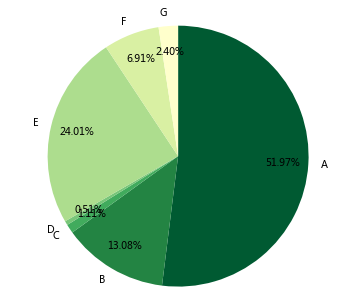

In [3]:
'''
 双十一当天在售的商品占比情况
 按照商品销售节奏分类，我们可以将商品分为7类
   A. 11.11前后及当天都在售 → 一直在售
   B. 11.11之后停止销售 → 双十一后停止销售
   C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售
   D. 11.11开始销售且当天停止 → 仅双十一当天有售
   E. 11.5 - 11.10 → 双十一前停止销售
   F. 仅11.11当天停止销售 → 仅双十一当天停止销售
   G. 11.12开始销售 → 双十一后上架

'''

data1 = df[['id','title','店名','date']]                                  # 筛选数据
#data1.head()
d1 = data1.groupby(by='id').agg(['min','max'])['date']                    # 统计不同的商品的销售的开始时间,截止时间
#d1.head()
id_11 = data1[data1['date']==11]['id'].unique()                           # 筛选双十一当天在售的商品  
d2 = pd.DataFrame({'id':id_11,'双十一当天是否售卖':True})

id_date = pd.merge(d1,d2,left_index=True,right_on='id',how='left')        # 合并数据
id_date['双十一当天是否售卖'][id_date['双十一当天是否售卖']!=True] = False
#id_date.head()

m = len(data1['id'].unique())
m_11 = len(id_11)
m_11_per = m_11/m
print(f'商品的总数为:{(m)}')
print(f'双十一销售的商品总数为{(m_11)},占比为{m_11_per*100}')
print(f"品牌总数为:{len(data1['店名'].unique())}")

id_date['type'] = '待分类'
id_date['type'][(id_date['min']<11)&(id_date['max']>11)] = 'A'             # 11.11前后及当天都在售 → 一直在售
id_date['type'][(id_date['min']<11)&(id_date['max']==11)] = 'B'            # 11.11之后停止销售 → 双十一后停止销售
id_date['type'][(id_date['min']==11)&(id_date['max']>11)] = 'C'            # 11.11开始销售并当天不停止 → 双十一当天上架并持续在售
id_date['type'][(id_date['min']==11)&(id_date['max']==11)] = 'D'           # 11.11开始销售且当天停止 → 仅双十一当天有售
id_date['type'][id_date['双十一当天是否售卖']==False] = 'F'                # 仅11.11当天停止销售 → 仅双十一当天停止销售
id_date['type'][(id_date['max']<11)] = 'E'                                 # 11.5 - 11.10 → 双十一前停止销售
id_date['type'][(id_date['min']>11)] = 'G'                                 # 11.12开始销售 → 双十一后上架

result1 = id_date['type'].value_counts()                                   # 计算不同类别商品的数量
result1 = result1.loc[['A','B','C','D','E','F','G']]                       # 调整顺序

from bokeh.palettes import brewer
colori = brewer['YlGn'][7]                                                 # 设置调色盘

plt.axis('equal')                                                          # 设置长宽相等
plt.pie(result1,labels=result1.index,autopct='%.2f%%',
        pctdistance=0.8,labeldistance=1.1,
        startangle=90,radius=1.5,counterclock=False,colors=colori)

In [4]:
'''
 未参与双十一当天活动的商品，在双十一之后的去向如何？
   con1 → 暂时下架（F）
   con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”）
   con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字），字符串查找特定字符 dataframe.str.contains('预售')
   con4 → 彻底下架（E中部分数据），可忽略
'''

id_not11 = id_date[id_date['双十一当天是否售卖']==False]

df_not11 = id_not11[['id','type']]
data_not11 = pd.merge(df_not11,df,on='id',how='left')

id_con1 = id_date['id'][id_date['type']=='F'].values

data_con2 = data_not11[['id','title','date']].groupby(['id','title']).count()
title_count = data_con2.reset_index()['id'].value_counts()
id_con2 = title_count[title_count>1].index

data_con3 = data_not11[data_not11['title'].str.contains('预售')]
id_con3 = data_con3['id'].value_counts().index

print(f'未参加双十一打折活动:\n暂时下架有{len(id_con1)},\n重新上架的有{len(id_con2)},\n预售的商品有{len(id_con3)}')



未参加双十一打折活动:
暂时下架有242,
重新上架的有110,
预售的商品有453


In [5]:
'''
 真正参与双十一活动的品牌有哪些？其各个品牌参与双十一活动的商品数量分布是怎样的？
 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品 （相加后再去重，去掉预售且当天在售的商品）
'''

data_11sale = id_11
id_sale_final = np.hstack((data_11sale,id_con3))

result2_id = pd.DataFrame({'id':id_sale_final})

x1 = pd.DataFrame({'id':id_11})
x1_df = pd.merge(x1,df,on='id',how='left')
brand_11sale = x1_df.groupby('店名')['id'].count()

x2 = pd.DataFrame({'id':id_con3})
x2_df = pd.merge(x2,df,on='id',how='left')
brand_ys = x2_df.groupby('店名')['id'].count()

result2_data = pd.DataFrame({'当天参加活动的商品数量':brand_11sale,
                             '预售的商品数量':brand_ys})

result2_data['参加双十一活动的商品总数'] = result2_data['当天参加活动的商品数量'] + result2_data['预售的商品数量']

result2_data.sort_values(by='参加双十一活动的商品总数',inplace=True,ascending=False)
result2_data.head()



,当天参加活动的商品数量,预售的商品数量,参加双十一活动的商品总数
店名,,,
悦诗风吟,2709,60,2769
佰草集,1840,182,2022
欧莱雅,1644,115,1759
雅诗兰黛,1392,239,1631
倩碧,1304,299,1603


In [6]:
# 制作堆叠图查看各个品牌参与双十一活动的商品数量分布

from bokeh.models import HoverTool
from bokeh.core.properties import value

lst_brand = result2_data.index.tolist()                       # 获取品牌
lst_type = result2_data.columns.tolist()[:2]                  # 获取参加当天参加活动和预售的商品的columns
colors = ["#718dbf" ,"#e84d60"]                               # 柱状图颜色参数

result2_data.index.name = 'brand'                             # 修改index和column为英文
result2_data.columns = ['sale_on_11','presell','sum']

source = ColumnDataSource(data = result2_data)

hover = HoverTool(tooltips=[('品牌','@brand'),                # 设置标签显示内容  
                            ('当天参加活动的商品数量','@sale_on_11'),
                            ('预售的商品数量','@presell'),
                            ('参加双十一活动的商品总数','@sum')])

p = figure(x_range = lst_brand,plot_width=900,plot_height=350, # 构建绘图空间
           title='各个品牌参加双十一的数量分布',
           tools=[hover,'reset,xwheel_zoom,pan,crosshair'])

p.vbar_stack(lst_type,                                         # 设置堆叠值,这里source中包含了不同年份的值，years变量用于识别不同堆叠层
             x='brand',                                        # 设置x坐标 
             source=source,                                    # 绘制堆叠图 
             width=.9,alpha=.8,color=colors,muted_color='b',muted_alpha=.2,
             legend=[value(x) for x in lst_type])
 
p.xgrid.grid_line_color = None                                  # 设置其他参数 
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = 'top_right'
p.legend.orientation = 'horizontal'
p.legend.click_policy = 'mute'

show(p)

'''
2、哪些商品真的在打折呢？
要求：
① 针对每个商品，评估其打折的情况
② 针对在打折的商品，其折扣率是多少
   * 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量
③ 按照品牌分析，不同品牌的打折力度
   * 用bokeh绘制浮动散点图，y坐标为品牌类型，x坐标为折扣力度
提示：
① 打折情况评估方法：
   真打折：商品的价格在10天内有波动、双11价格为10天内最低价、不存在涨价现象
   不打折：商品价格无变化
② 针对每个商品做price字段的value值统计，查看价格是否有波动，可以先用pd.cut将date分为不同周期：'双十一前','双十一当天','双十一后'，得到period字段
   data[['id','price','date']].groupby(['id','price']).min()
   针对统计出来的结果，如果按照id和price分组仍只有一个唯一值，则说明价格未变，没打折；否则为打折
③ 折扣率 = 双十一当天价格 / 双十一之前价格
④ 作图过程中，清除掉折扣率大于95%的数据

'''

In [11]:
'''
 针对每个商品，评估其打折的情况
   真打折：商品的价格在10天内有波动、双11价格为10天内最低价、不存在涨价现象
   不打折：商品价格无变化
'''

data2 = df[['id','title','店名','date','price']]
data2['periord'] = pd.cut(data2['date'],[4,10,11,14],labels=['双十一前','双十一当天','双十一后'])
#print(data2.head())

price = data2[['id','price','periord']].groupby(['id','price']).min()    # 针对每个商品做price字段的value值统计，查看价格是否有波动
price.reset_index(inplace=True)
#print(price.head())

id_count = price['id'].value_counts()
id_type1 = id_count[id_count == 1].index                                 # 不打折
id_type2 = id_count[id_count != 1].index                                 # 打折

n1 = len(id_type1)
n2 = len(id_type2)
print('真打折的商品数量约占比%.2f%%，不打折的商品数量约占比%.2f%%' % (n2/len(id_count)*100, n1/len(id_count)*100))

真打折的商品数量约占比24.73%，不打折的商品数量约占比75.27%


In [15]:
# 针对在打折的商品，其折扣率是多少

result3_data1 = data2[['id','price','periord','店名']].groupby(['id','periord']).min()
result3_data1.reset_index(inplace=True)
#print(result3_data1.head())

result3_before11 = result3_data1[result3_data1['periord']=='双十一前']
result3_at11 = result3_data1[result3_data1['periord']=='双十一当天']
result3_data2 = pd.merge(result3_at11,result3_before11,on='id')          # 筛选出商品双十一当天及双十一之前的价格

result3_data2['zkl'] = result3_data2['price_x']/result3_data2['price_y'] # 计算折扣率


In [31]:
# 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量占比

bokeh_data = result3_data2[['id','zkl']].dropna()
bokeh_data['zkl_range'] = pd.cut(bokeh_data['zkl'],bins=np.linspace(0,1,21)).astype(np.str)
bokeh_data2 = bokeh_data.groupby(['zkl_range']).count().iloc[:-1]        # 这里去掉折扣率在0.95-1之间的数据，该区间内数据zkl大部分为1，不打折
bokeh_data2['zkl_per'] = bokeh_data2['zkl']/bokeh_data2['zkl'].sum()     # 将数据按照折扣率拆分为不同区间，并统计不同折扣率的商品数量

source = ColumnDataSource(bokeh_data2)
lst_brand = bokeh_data2.index.tolist()

hover = HoverTool(tooltips=[('折扣率', '@zkl')])                          # 设置标签显示内容

p = figure(x_range=lst_brand, plot_width=900, plot_height=350,            # 设置绘图空间
           title="商品折扣率统计",
           tools=[hover,'reset,xwheel_zoom,pan,crosshair'])

p.line(x='zkl_range',y='zkl_per',source=source,
       line_width=2,line_alpha=.8,line_color='black',line_dash=[10,4])

p.circle(x='zkl_range',y='zkl_per',source=source,size=8,color='red',alpha=.8)

p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None

show(p)

In [ ]:
'''
3、商家营销套路挖掘？
要求：
① 解析出不同品牌的参与打折商品比例及折扣力度，并做散点图，总结打折套路
   * 用bokeh绘制散点图，x轴为参与打折商品比例，y轴为折扣力度，点的大小代表该品牌参加双11活动的商品总数
提示：
① 折扣力度为该品牌所有打折商品的折扣均值，这里去掉品牌中不打折的数据
② 绘制散点图后，可以将x、y轴绘制均值辅助线，将绘图空间分为四个象限，基于该象限来总结套路

'''

In [36]:
# 解析出不同品牌的参与打折商品比例及折扣力度，并做散点图，总结打折套路

data_zk = result3_data2[result3_data2['zkl']<0.95]         # 删除未打折数据
result4_zkld = data_zk.groupby(['店名_y'])['zkl'].mean()   # 筛选出不同品牌的折扣率

n_dz = data_zk['店名_y'].value_counts()
n_zs = result3_data2['店名_y'].value_counts()

result4_dzspbl = pd.DataFrame({'打折商品数':n_dz,           # 计算出不同品牌参与打折商品比例
                               '商品总数':n_zs})

result4_dzspbl['参与打折商品比例'] = result4_dzspbl['打折商品数']/result4_dzspbl['商品总数']

result4_dzspbl.dropna(inplace=True)
#print(result4_dzspbl.head())

result4_sum = result2_data.copy()                           # 筛选出品牌参加双11活动的商品总数

result4_data = pd.merge(pd.DataFrame(result4_zkld),result4_dzspbl,left_index=True,right_index=True,how='inner')
result4_data = pd.merge(result4_data,result4_sum,left_index=True,right_index=True,how='inner')

result4_data

,zkl,打折商品数,商品总数,参与打折商品比例,sale_on_11,presell,sum
佰草集,0.576060,186.0,261,0.712644,1840,182,2022
兰芝,0.440332,3.0,148,0.020270,817,24,841
兰蔻,0.761905,1.0,158,0.006329,917,202,1119
妮维雅,0.888144,90.0,156,0.576923,1189,78,1267
娇兰,0.798122,1.0,145,0.006897,805,365,1170
悦诗风吟,0.624859,17.0,326,0.052147,2709,60,2769
欧珀莱,0.569535,8.0,181,0.044199,991,110,1101
欧莱雅,0.772428,74.0,239,0.309623,1644,115,1759
玉兰油,0.813539,41.0,141,0.290780,588,90,678
相宜本草,0.528362,90.0,167,0.538922,844,79,923


In [43]:
# 用bokeh绘制散点图，x轴为参与打折商品比例，y轴为折扣力度，点的大小代表该品牌参加双11活动的商品总数

from bokeh.models.annotations import Span                    # 导入Span模块
from bokeh.models.annotations import Label                   # 导入Label模块
from bokeh.models.annotations import BoxAnnotation           # 导入BoxAnnotation模块

bokeh_data = result4_data[['zkl','sum','参与打折商品比例']]
bokeh_data.columns = ['zkl','amount','per']
bokeh_data['size'] = bokeh_data['amount']*0.03
source = ColumnDataSource(bokeh_data)

x_mean = bokeh_data['per'].mean()
y_mean = bokeh_data['zkl'].mean()

hover = HoverTool(tooltips=[("品牌", "@index"),
                            ("折扣率","@zkl"),
                            ("商品总数","@amount"),
                            ("参与打折商品比例","@per")])

p = figure(plot_width=600,plot_height=600,
           title='各个品牌打折套路分析',
           tools=[hover,'box_select,reset,wheel_zoom,pan,crosshair'])

p.circle_x(x='per',y='zkl',source=source,size='size',            # 散点图        
           fill_color='red',line_color='black',fill_alpha=.6,line_dash=[8,3])

p.ygrid.grid_line_dash = [6,4]
p.xgrid.grid_line_dash = [6,4]

x = Span(location=x_mean,dimension='height',line_color='green',line_alpha=.7,line_width=1.5,line_dash=[6,4])
y = Span(location=x_mean,dimension='width',line_color='green',line_alpha=.7,line_width=1.5,line_dash=[6,4])

p.add_layout(x)
p.add_layout(y)

be1 = BoxAnnotation(bottom=y_mean,right=x_mean,fill_alpha=.1,fill_color='olive')
label1 = Label(x=.1,y=.55,text='少量大打折',text_font_size='10pt')
p.add_layout(be1)                                               # 绘制第一象限
p.add_layout(label1)

be2 = BoxAnnotation(bottom=y_mean,left=x_mean,fill_alpha=.1,fill_color='firebrick')
label2 = Label(x=.7,y=.55,text='大量大打折',text_font_size='10pt')
p.add_layout(be2)                                               # 绘制第二象限
p.add_layout(label2)

be3 = BoxAnnotation(top=y_mean,right=x_mean,fill_alpha=.1,fill_color='firebrick')
label3 = Label(x=.1,y=.8,text='少量少打折',text_font_size='10pt')
p.add_layout(be3)                                               # 绘制第三象限
p.add_layout(label3)

be4 = BoxAnnotation(top=y_mean,left=x_mean,fill_alpha=.1,fill_color='olive')
label4 = Label(x=.7,y=.8,text='少量大打折',text_font_size='10pt')
p.add_layout(be4)                                               # 绘制第四象限
p.add_layout(label4)

show(p)

In [ ]:
'''
结论：
少量少打折：包括雅诗兰黛、娇兰、兰蔻、薇姿、玉兰油等共5个品牌。
少量大打折：包括悦诗风吟、兰芝、欧珀莱等3个品牌。该类品牌的打折商品较少，但折扣力度较大。
大量小打折：包括妮维雅、美宝莲、蜜丝佛陀等3个品牌。该类型有半数以上的商品都参与了打折活动，但折扣力度并不大。
大量大打折：包括相宜本草、佰草集、自然堂等三大国产品牌。这些品牌不仅有90%以上的商品参与了折扣活动，而且折扣力度很大。
'''